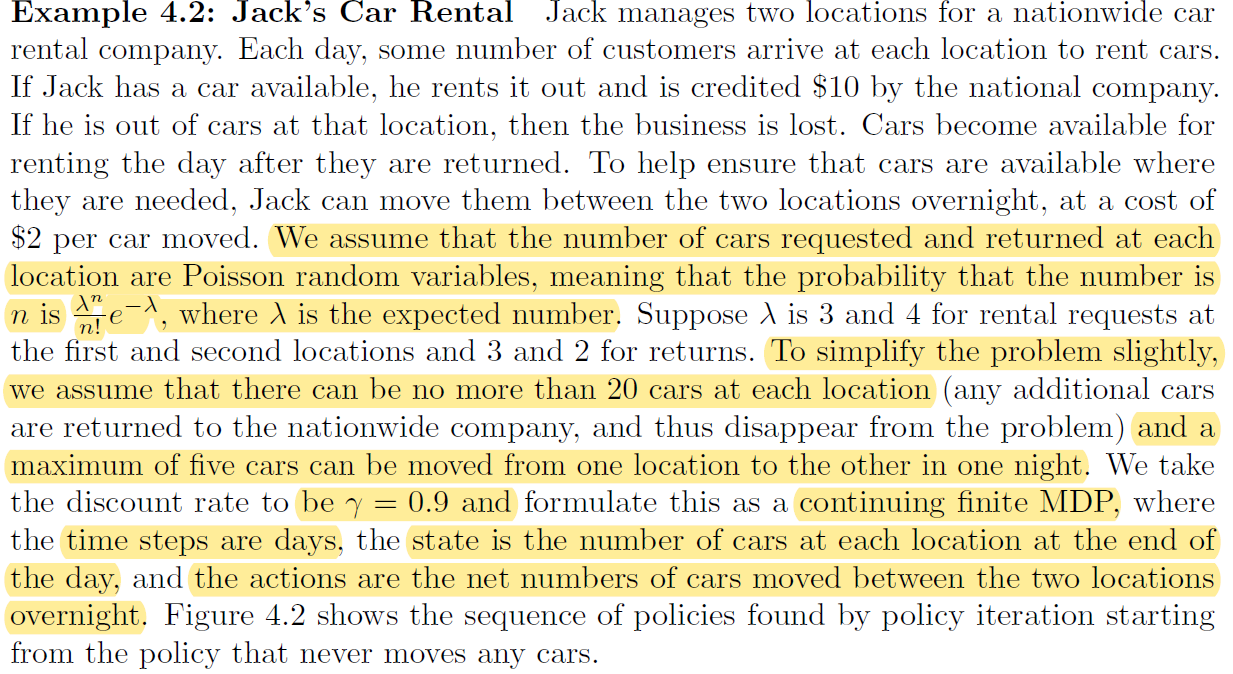

# Write program to solve Jack Car Rental problem as shown above

`Observations`:
- state is a 2 element vector with each element indicating car at storeA and storeB respectively
- Number of states are 21x21 since each store can have min 0 car and max 20 cars
- Action here means moving cars between the two stores, only maximum of 5 cars can be moved at the end of the day
- We assume action belong to a set [-5,-4,-3,....,3,4,5] where postive action implies car moving from storeA->storeB and negative implies from storeB->storeA
- This is a deterministic policy (there is only 1 action which happens with probability 1)
- Reward: There is a negative reward everytime car is moved in between stores, further there is positive reward every time a car is rented out from a store (NOTE: negative reward happens with probability 1, while positive reward depends on the probability of event, event in this case is a sample of 4 independent random variables, return@storeA, rental@storeA, return@storeB, rental@storeB), so to find the reward we have to find expected returns for all possible outcomes 
- Goal: Determine the policy (in this case a deterministic one) which maximizes the expected reward
- Few clarifications: Agent in this case is Jack who is suppose to take action based on the state, environment in this case is causing the rentals and returns @ both stores, hence influencing a positive reward
- One Time step: This corresponds to the period starting from moving the cars b/w the stores at night and then until next night when you are ready to move the cars again. In between the environment causes the rentals and returns at both stores

`rough thoughts on how we are going to code this`: <br>
`class Jack`:
- class attributes
    - negative reward
    - positive reward
    - discount factor
- Attributes:
    - return rates
    - rental rates
- Methods:
    - get_return_samples
    - get_rental_samples

`class JackPolicy`:
- Attributes:
    - states
    - state value function (matrix of size 21x21)
    - policy (matrix of size 21x21)
- Methods:
    - PolicyEvaluation
    - PolicyImprovement
    - PolicyIteration
    - show (to display the converged policy and value function)

In [60]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import poisson

In [91]:
class Jack():
    neg_reward = -2
    pos_reward = 10
    discount_fac = 0.9
    max_cars = 20
    max_cars_transfer = 5 
    
    def __init__(self, ret_rate, rent_rate, eps_prob): # these are the lambdas for the corresponding poisson distbns
        self.ret_rate  = ret_rate
        self.rent_rate = rent_rate
        self.eps_prob  = eps_prob
        self.ret_sample, self.ret_prob = self.gen_samples(self.ret_rate, self.eps_prob)
        self.rent_sample, self.rent_prob = self.gen_samples(self.rent_rate, self.eps_prob)
        
    
    def gen_samples(self, rate, eps_prob): # modelled as poisson distribn
        '''
        We will generate samples from this distiribution as long as the pmf is above some epsilon_prob
        There is no point in generating samples from distribution which has very low prob
        
        '''
        samples = []
        samples_prob = []
        sample = 0 # NOTE: init sample will always start from 0 since cars to be rented or returned are >=0
        while(1):
            prob = poisson.pmf(sample, rate)
            if prob > eps_prob:
                samples.append(sample)
                samples_prob.append(prob)
            else:
                if sample > rate: # crossed the mean point
                    break
            sample +=1
        
        return samples, samples_prob/np.sum(samples_prob)   
       

In [92]:
eps_prob = 0.01
storeA = Jack(3,3,eps_prob)
storeB = Jack(4,2,eps_prob)

In [19]:
storeA.ret_sample

[0, 1, 2, 3, 4, 5, 6, 7]

In [20]:
storeA.ret_prob

array([0.0503869 , 0.1511607 , 0.22674105, 0.22674105, 0.17005579,
       0.10203347, 0.05101674, 0.02186432])

In [27]:
sum(storeA.ret_prob)

0.9999999999999999

In [21]:
storeA.rent_sample

[0, 1, 2, 3, 4, 5, 6, 7]

In [22]:
storeA.rent_prob

array([0.0503869 , 0.1511607 , 0.22674105, 0.22674105, 0.17005579,
       0.10203347, 0.05101674, 0.02186432])

In [23]:
storeB.ret_sample

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [24]:
storeB.ret_prob

array([0.01846581, 0.07386323, 0.14772646, 0.19696861, 0.19696861,
       0.15757489, 0.10504993, 0.06002853, 0.03001426, 0.01333967])

In [25]:
storeB.rent_sample

[0, 1, 2, 3, 4, 5, 6]

In [26]:
storeB.rent_prob

array([0.13595166, 0.27190332, 0.27190332, 0.18126888, 0.09063444,
       0.03625378, 0.01208459])

In [81]:
class JackPolicy():
    def __init__(self, storeA, storeB, max_step_eval=20, eps_eval=0.1, max_steps_iter=20):
        self.storeA = storeA
        self.storeB = storeB
        self.states = [(x,y) for x in range(self.max_cars+1) for y in range(self.max_cars+1)] # list of tuples
        self.stateval = np.zeros((self.max_cars+1,self.max_cars+1)) # initial value of state value function
        # Note: as initiallized below, starting policy is for action = 0 for all states: Do Nothing!
        self.policy   = np.zeros((self.max_cars+1,self.max_cars+1)) # there is only 1 action possible per state in this problem
        self.max_step_eval = max_step_eval # maximum number of steps for policy evaluation
        self.eps_eval = eps_eval # for breaking out of policy evaluation
        self.max_steps_iter = max_steps_iter # maximum num of steps for policy iteration
        
        
    def __getattr__(self, key):
        return getattr(self.__dict__['storeA'], key)
        
    def policy_eval(self):
        pass
    
    def policy_improvement(self):
        pass
    
    def policy_iteration(self):
        pass
    
    def show(self):
        pass

In [82]:
jp = JackPolicy(storeA, storeB)

In [83]:
jp.storeA.ret_prob

array([0.0503869 , 0.1511607 , 0.22674105, 0.22674105, 0.17005579,
       0.10203347, 0.05101674, 0.02186432])

## Now lets code policy evaluation function:
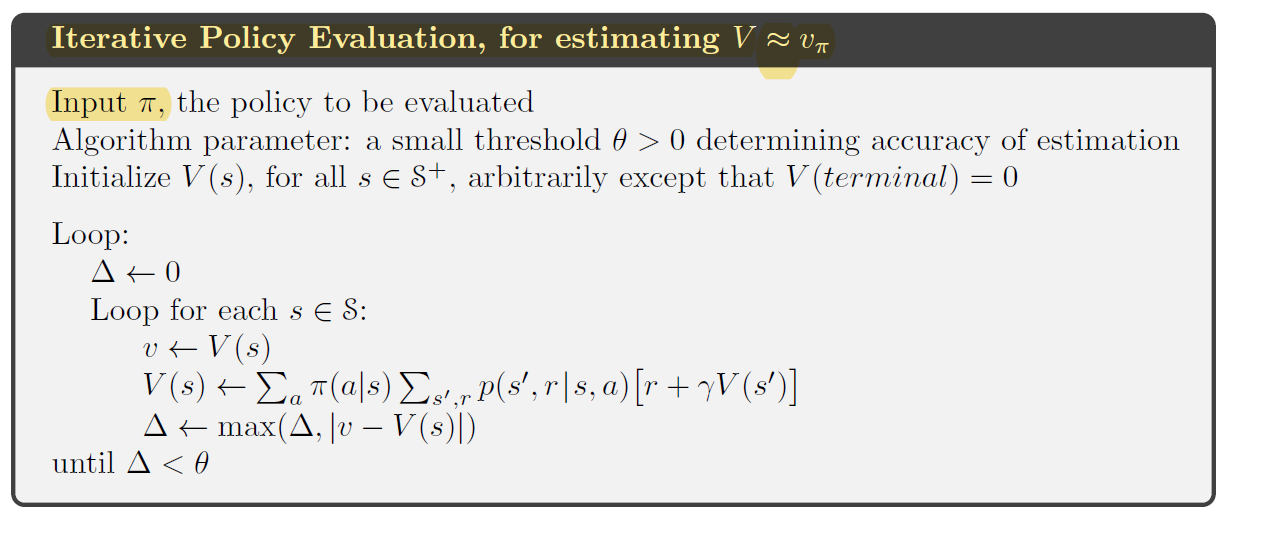

In [87]:
class JackPolicy():
    def __init__(self, storeA, storeB, max_step_eval=20, eps_eval=0.1, max_steps_iter=20):
        self.storeA = storeA
        self.storeB = storeB
        self.states = [(x,y) for x in range(self.max_cars+1) for y in range(self.max_cars+1)] # list of tuples
        self.stateval = np.zeros((self.max_cars+1,self.max_cars+1)) # initial value of state value function
        # Note: as initiallized below, starting policy is for action = 0 for all states: Do Nothing!
        self.policy   = np.zeros((self.max_cars+1,self.max_cars+1)) # there is only 1 action possible per state in this problem
        self.max_step_eval = max_step_eval # maximum number of steps for policy evaluation
        self.eps_eval = eps_eval # for breaking out of policy evaluation
        self.max_steps_iter = max_steps_iter # maximum num of steps for policy iteration
        
        
    def __getattr__(self, key):
        return getattr(self.__dict__['storeA'], key)
        
    
    def policy_eval(self):         
        while(self.max_step_eval > 0):
            self.max_step_eval -= 1
            delta = 0
            # loop over every state
            for i in range(self.stateval.shape[0]):
                for j in range(self.stateval.shape[1]):
                    old_stateval = self.stateval[i][j]
                    self.stateval[i][j]  = self.expected_return()
                    delta = np.max(delta,np.abs(old_stateval - self.stateval[i][j]))
            
            if delta < self.eps_eval:
                break
        
        
    def expected_return(self, state, action):
        '''
        state: list of integer corresponding to state (i.e cars@storeA and cars@storeB)
        action: integer corresponding to the policy under evaluation for the given state (number b/w -5 and 5)
        '''
       
        # because of the action of moving cars, the state will change so update the state value
        state = [min(max(state[0]-action,0), self.max_cars), min(max(state[1]+action,0), self.max_cars)] # make sure that number of 0<= #cars <= 20
        
        # give the negative reward due to movement of cars
        reward = self.neg_reward * abs(action)   # this reward is given with prob 1
        
        # after the above update of the state, the environment starts acting leading to all possible state outcomes as a 
        # consequence of returns and rental at both stores
        
        for rent_storeA in self.storeA.rent_sample: # this is list, hence iterable
            for rent_storeB in self.storeA.rent_sample: # this is list, hence iterable
                for ret_storeA in self.storeA.ret_sample: # this is list, hence iterable
                    for ret_storeB in self.storeB.ret_sample: # this is list, hence iterable
                        
                        # probability of this event is multplication of indiv. (since indep. RVs)
                        prob = self.storeA.rent_prob[rent_storeA] * self.storeA.prob[rent_storeB] \
                               * self.storeA.ret_prob[ret_storeA] * self.storeB.ret_prob[ret_storeB]
                            
                        # compute the postive reward, before that we have to find number of cars that can be rented out
                        cars_rent_A = min(state[0],rent_storeA)
                        cars_rent_B = min(state[1],rent_storeB)
                        pos_reward = (cars_rent_A + cars_rent_B)*self.pos_reward
                        
                        # as a consequence of car rentals and returns of this event, the state will change, compute the new state
                        tmp_state = [0,0]
                        tmp_state[0] = min(max(state[0] - cars_rent_A + ret_storeA, 0), self.max_cars)
                        tmp_state[1] = min(max(state[1] - cars_rent_A + ret_storeA, 0), self.max_cars)
                        
                        # compute the discounted reward for the event (or state) and keep accumulating
                        reward += prob*(pos_reward + self.discount_fac * self.stateval[tmp_state[0], tmp_state[1]])
        
        
        return reward
        
    
    def policy_improvement(self):
        pass
    
    def policy_iteration(self):
        pass
    
    def show(self):
        pass

## Now lets code policy improvement function
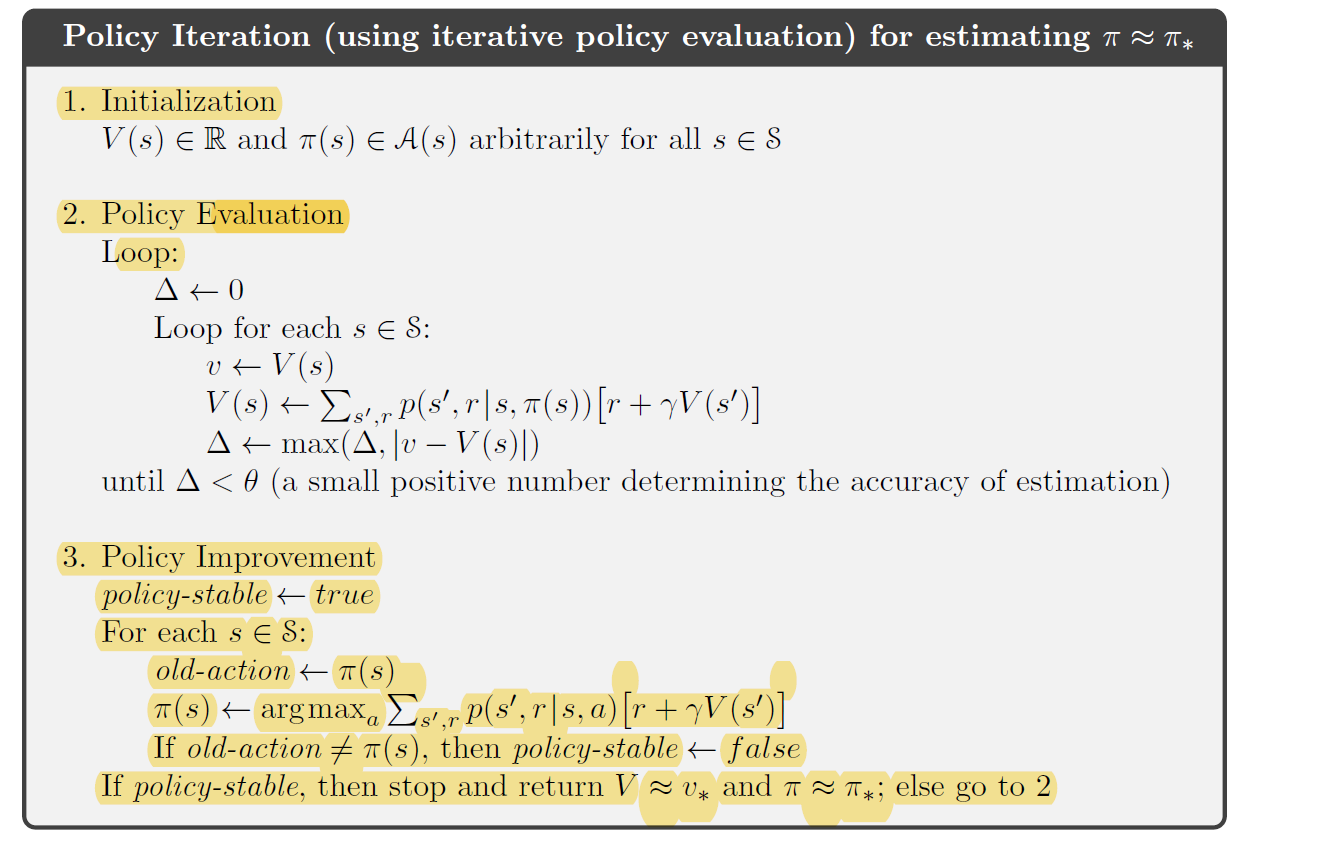

In [194]:
class JackPolicy():
    def __init__(self, storeA, storeB, max_steps_eval=10, eps_eval=0.1, max_steps_iter=4):
        self.storeA = storeA
        self.storeB = storeB
        self.states = [(x,y) for x in range(self.max_cars+1) for y in range(self.max_cars+1)] # list of tuples
        self.stateval = np.zeros((self.max_cars+1,self.max_cars+1)) # initial value of state value function
        # Note: as initiallized below, starting policy is for action = 0 for all states: Do Nothing!
        self.policy   = np.zeros((self.max_cars+1,self.max_cars+1)) # there is only 1 action possible per state in this problem
        self.max_steps_eval = max_steps_eval # maximum number of steps for policy evaluation
        self.eps_eval = eps_eval # for breaking out of policy evaluation
        self.max_steps_iter = max_steps_iter # maximum num of steps for policy iteration
        
        
    def __getattr__(self, key):
        return getattr(self.__dict__['storeA'], key)
        
    
    def policy_eval(self): 
        print("--- starting New policy eval iteration -----")
        counter = 0
        while(counter < self.max_steps_eval):
            print("--- policy eval iteration -----")
            counter += 1
            delta = 0
            # loop over every state
            for i in range(self.stateval.shape[0]):
                for j in range(self.stateval.shape[1]):
                    old_stateval = self.stateval[i][j]
                    self.stateval[i][j]  = self.expected_return([i,j], self.policy[i][j])
                    delta = np.maximum(delta,np.abs(old_stateval - self.stateval[i][j]))
            print(delta)
            if delta < self.eps_eval:
                break
        
        
    def expected_return(self, state, action):
        '''
        state: list of integer corresponding to state (i.e cars@storeA and cars@storeB)
        action: integer corresponding to the policy under evaluation for the given state (number b/w -5 and 5)
        '''
       
        # because of the action of moving cars, the state will change so update the state value
        state = [min(max(state[0]-action,0), self.max_cars), min(max(state[1]+action,0), self.max_cars)] # make sure that number of 0<= #cars <= 20
        
        # give the negative reward due to movement of cars
        reward = self.neg_reward * abs(action)   # this reward is given with prob 1
        
        # after the above update of the state, the environment starts acting leading to all possible state outcomes as a 
        # consequence of returns and rental at both stores
        
        for rent_storeA in self.storeA.rent_sample: # this is list, hence iterable
            for rent_storeB in self.storeA.rent_sample: # this is list, hence iterable
                for ret_storeA in self.storeA.ret_sample: # this is list, hence iterable
                    for ret_storeB in self.storeB.ret_sample: # this is list, hence iterable
                        
                        # probability of this event is multplication of indiv. (since indep. RVs)
                        prob = self.storeA.rent_prob[rent_storeA] * self.storeA.ret_prob[rent_storeB] \
                               * self.storeA.ret_prob[ret_storeA] * self.storeB.ret_prob[ret_storeB]
                            
                        # compute the postive reward, before that we have to find number of cars that can be rented out
                        cars_rent_A = min(state[0],rent_storeA)
                        cars_rent_B = min(state[1],rent_storeB)
                        pos_reward = (cars_rent_A + cars_rent_B)*self.pos_reward
                        
                        # as a consequence of car rentals and returns of this event, the state will change, compute the new state
                        tmp_state = [0,0]
                        tmp_state[0] = int(min(max(state[0] - cars_rent_A + ret_storeA, 0), self.max_cars))
                        tmp_state[1] = int(min(max(state[1] - cars_rent_A + ret_storeA, 0), self.max_cars))
                                                
                        # compute the discounted reward for the event (or state) and keep accumulating
                        reward += prob*(pos_reward + self.discount_fac * self.stateval[tmp_state[0], tmp_state[1]])
        
        
        return reward
        
    
    def policy_improvement(self):
        policy_stable = 0
        
        # loop over every state
        for i in range(self.stateval.shape[0]):
            for j in range(self.stateval.shape[1]):
                old_action = self.policy[i][j]
                # Now try every possible action and compute the expected reward and choose greedy action
                # first find the possible actions given the state
                act_12 = min(i,self.max_cars_transfer) # you can transfer this from storeA->storeB
                act_21 = -1*min(j,self.max_cars_transfer) # you can transfer this from storeB->storeA
                
                max_reward = -1e9
                for action in range(act_21, act_12+1): # go through every possible action given the state
                    reward = self.expected_return([i,j], action)
                    if reward > max_reward:
                        max_reward = reward
                        self.policy[i][j] = action #update policy to greedy policy
                
                if old_action!=self.policy[i][j]:
                    policy_stable += 1 # if any of the state policy is changed, it will increment the counter
                    
        # check if policy is stable
        if np.sum(policy_stable) > 0:
            return False
        else: return True
    
    def policy_iteration(self, save_intermediate=False):
        counter = 0
        while(counter < self.max_steps_iter):            
            self.policy_eval()
            flag = self.policy_improvement()
            if save_intermediate:
                outFile = 'Policy_' + str(counter)
                np.save(outFile, self.policy)
                outFile = 'StateVal_' + str(counter)
                np.save(outFile, self.stateval)
                
            if flag==True:
                print("Policy improvement converged..., exiting early!")
                break
                
            counter += 1
        
        
        return self.stateval, self.policy
    
    def show(self):
        pass

In [195]:
jp = JackPolicy(storeA, storeB)
stateval, policy = jp.policy_iteration(save_intermediate=True)

--- starting New policy eval iteration -----
--- policy eval iteration -----
93.57878408009518
--- policy eval iteration -----
78.54610518863413
--- policy eval iteration -----
65.89179680341158
--- policy eval iteration -----
55.25880218188627
--- policy eval iteration -----
46.43316044815609
--- policy eval iteration -----
40.58503241743301
--- policy eval iteration -----
35.15859053848271
--- policy eval iteration -----
30.2906743424208
--- policy eval iteration -----
25.999613418181752
--- policy eval iteration -----
22.256198123983154
--- starting New policy eval iteration -----
--- policy eval iteration -----
129.66322452472582
--- policy eval iteration -----
29.185769431355425
--- policy eval iteration -----
14.24704991064118
--- policy eval iteration -----
11.733839657494457
--- policy eval iteration -----
9.965008749289893
--- policy eval iteration -----
8.46494458875469
--- policy eval iteration -----
7.185673624503806
--- policy eval iteration -----
6.096059846267167
--- pol

In [198]:
#after 5th pass
stateval_4 = np.load('StateVal_4.npy')
policy_4   = np.load('Policy_4.npy')
#after 4th pass
stateval_3 = np.load('StateVal_3.npy')
policy_3   = np.load('Policy_3.npy')
#after 3rd pass
stateval_2 = np.load('StateVal_2.npy')
policy_2   = np.load('Policy_2.npy')
#after 2nd pass
stateval_1 = np.load('StateVal_1.npy')
policy_1   = np.load('Policy_1.npy')
#after 1st pass
stateval_0 = np.load('StateVal_0.npy')
policy_0   = np.load('Policy_0.npy')

Text(0.5, 1.0, 'Policy after 5 Iterations')

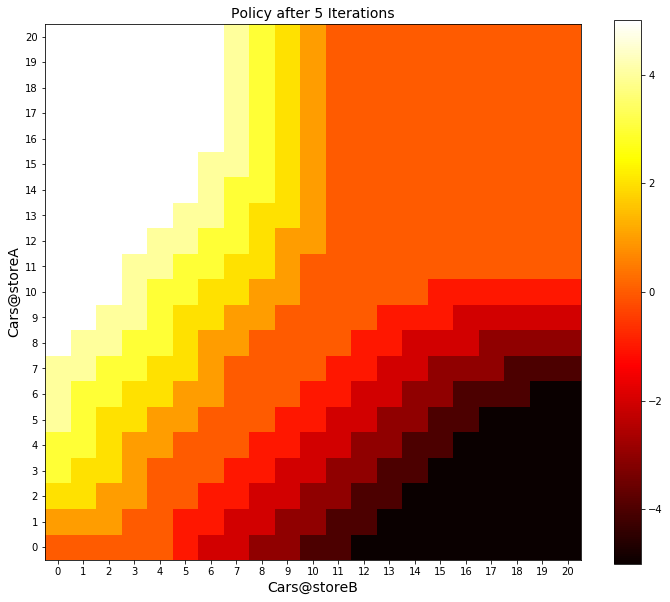

In [199]:
fig, ax = plt.subplots(figsize=(12,10))
heatmap = ax.imshow(policy_4, cmap='hot') # this plots axis=0 as y axis, axis=1 as x-axis
ax.invert_yaxis() # invert y axis labels
plt.colorbar(heatmap)
ax.set_xticks(np.arange(0,jp.max_cars+1))[0]
ax.set_yticks(np.arange(0,jp.max_cars+1))[0]
ax.set_ylabel("Cars@storeA", fontsize=14)
ax.set_xlabel("Cars@storeB", fontsize=14)
ax.set_title('Policy after 5 Iterations', fontsize=14)

Text(0.5, 1.0, 'Policy after 4 Iterations')

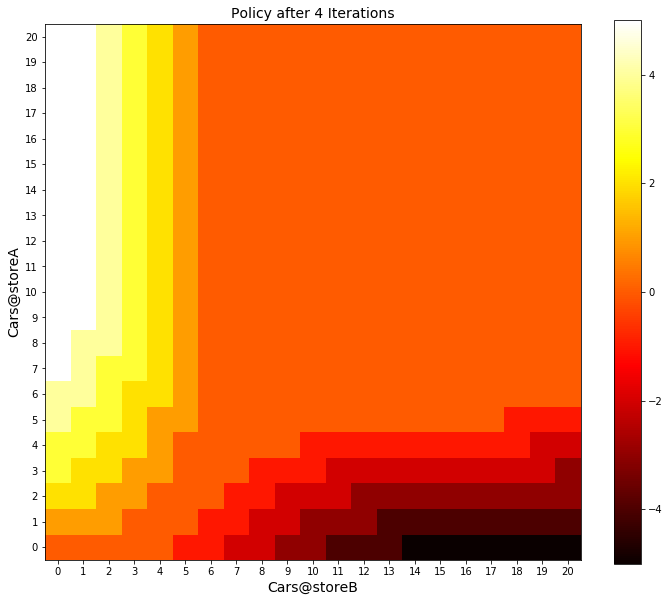

In [200]:
fig, ax = plt.subplots(figsize=(12,10))
heatmap = ax.imshow(policy_3, cmap='hot') # this plots axis=0 as y axis, axis=1 as x-axis
ax.invert_yaxis() # invert y axis labels
plt.colorbar(heatmap)
ax.set_xticks(np.arange(0,jp.max_cars+1))[0]
ax.set_yticks(np.arange(0,jp.max_cars+1))[0]
ax.set_ylabel("Cars@storeA", fontsize=14)
ax.set_xlabel("Cars@storeB", fontsize=14)
ax.set_title('Policy after 4 Iterations', fontsize=14)

Text(0.5, 1.0, 'Policy after 3 Iterations')

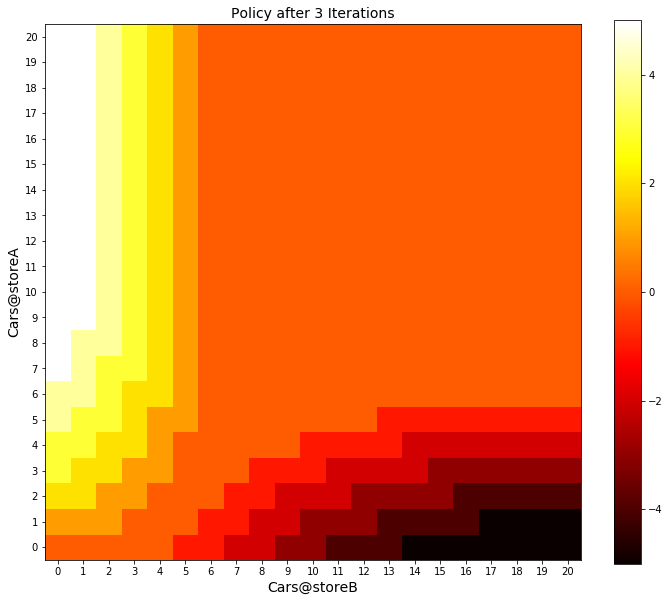

In [201]:
fig, ax = plt.subplots(figsize=(12,10))
heatmap = ax.imshow(policy_2, cmap='hot') # this plots axis=0 as y axis, axis=1 as x-axis
ax.invert_yaxis() # invert y axis labels
plt.colorbar(heatmap)
ax.set_xticks(np.arange(0,jp.max_cars+1))[0]
ax.set_yticks(np.arange(0,jp.max_cars+1))[0]
ax.set_ylabel("Cars@storeA", fontsize=14)
ax.set_xlabel("Cars@storeB", fontsize=14)
ax.set_title('Policy after 3 Iterations', fontsize=14)

Text(0.5, 1.0, 'Policy after 2 Iterations')

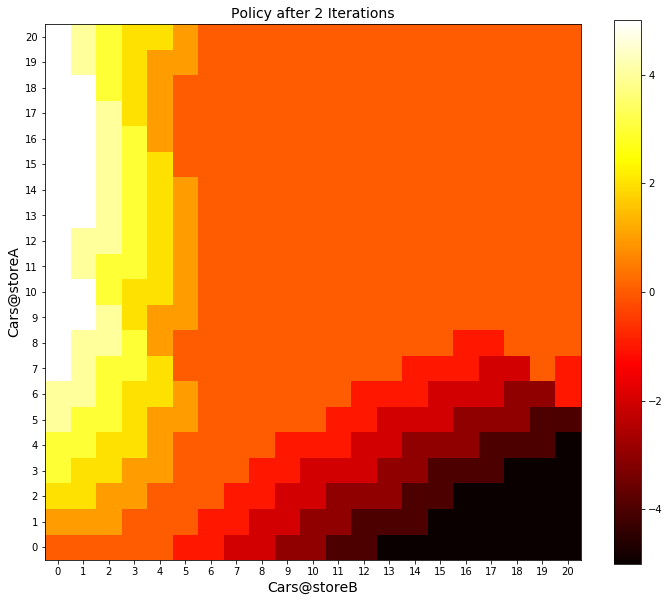

In [205]:
fig, ax = plt.subplots(figsize=(12,10))
heatmap = ax.imshow(policy_1, cmap='hot') # this plots axis=0 as y axis, axis=1 as x-axis
ax.invert_yaxis() # invert y axis labels
plt.colorbar(heatmap)
ax.set_xticks(np.arange(0,jp.max_cars+1))[0]
ax.set_yticks(np.arange(0,jp.max_cars+1))[0]
ax.set_ylabel("Cars@storeA", fontsize=14)
ax.set_xlabel("Cars@storeB", fontsize=14)
ax.set_title('Policy after 2 Iterations', fontsize=14)

Text(0.5, 1.0, 'Policy after 1 Iterations')

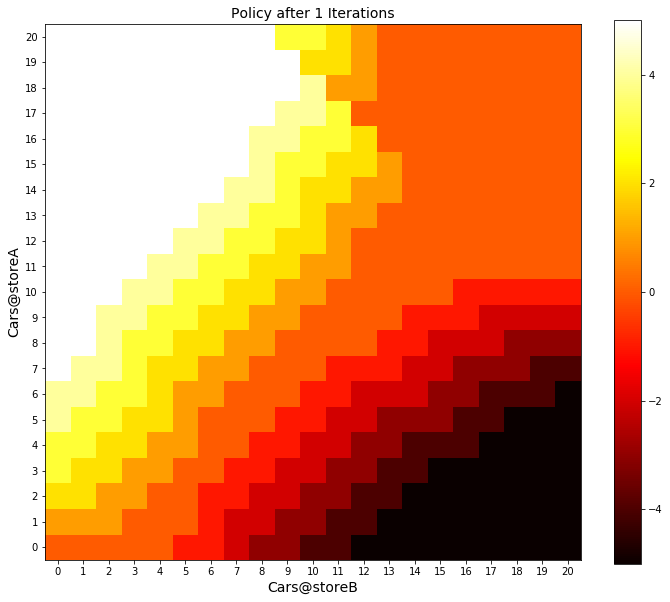

In [206]:
fig, ax = plt.subplots(figsize=(12,10))
heatmap = ax.imshow(policy_0, cmap='hot') # this plots axis=0 as y axis, axis=1 as x-axis
ax.invert_yaxis() # invert y axis labels
plt.colorbar(heatmap)
ax.set_xticks(np.arange(0,jp.max_cars+1))[0]
ax.set_yticks(np.arange(0,jp.max_cars+1))[0]
ax.set_ylabel("Cars@storeA", fontsize=14)
ax.set_xlabel("Cars@storeB", fontsize=14)
ax.set_title('Policy after 1 Iterations', fontsize=14)

Text(0.5, 1.0, 'State Value fn after 5 Iterations')

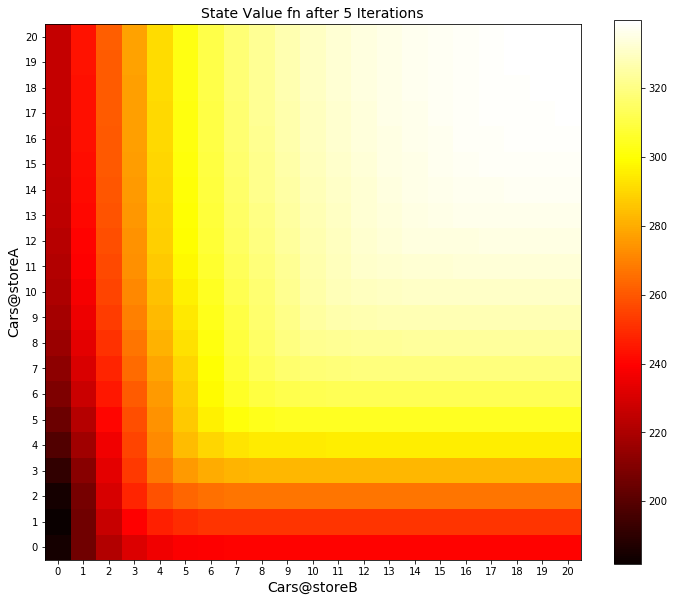

In [209]:
fig, ax = plt.subplots(figsize=(12,10))
heatmap = ax.imshow(stateval_4, cmap='hot') # this plots axis=0 as y axis, axis=1 as x-axis
ax.invert_yaxis() # invert y axis labels
plt.colorbar(heatmap)
ax.set_xticks(np.arange(0,jp.max_cars+1))[0]
ax.set_yticks(np.arange(0,jp.max_cars+1))[0]
ax.set_ylabel("Cars@storeA", fontsize=14)
ax.set_xlabel("Cars@storeB", fontsize=14)
ax.set_title('State Value fn after 5 Iterations', fontsize=14)

Text(0.5, 1.0, 'State Value fn after 4 Iterations')

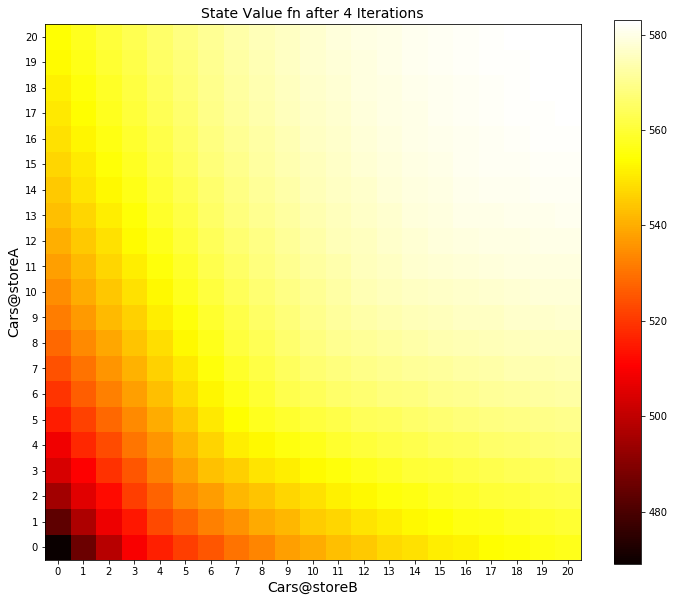

In [210]:
fig, ax = plt.subplots(figsize=(12,10))
heatmap = ax.imshow(stateval_3, cmap='hot') # this plots axis=0 as y axis, axis=1 as x-axis
ax.invert_yaxis() # invert y axis labels
plt.colorbar(heatmap)
ax.set_xticks(np.arange(0,jp.max_cars+1))[0]
ax.set_yticks(np.arange(0,jp.max_cars+1))[0]
ax.set_ylabel("Cars@storeA", fontsize=14)
ax.set_xlabel("Cars@storeB", fontsize=14)
ax.set_title('State Value fn after 4 Iterations', fontsize=14)

Text(0.5, 1.0, 'State Value fn after 3 Iterations')

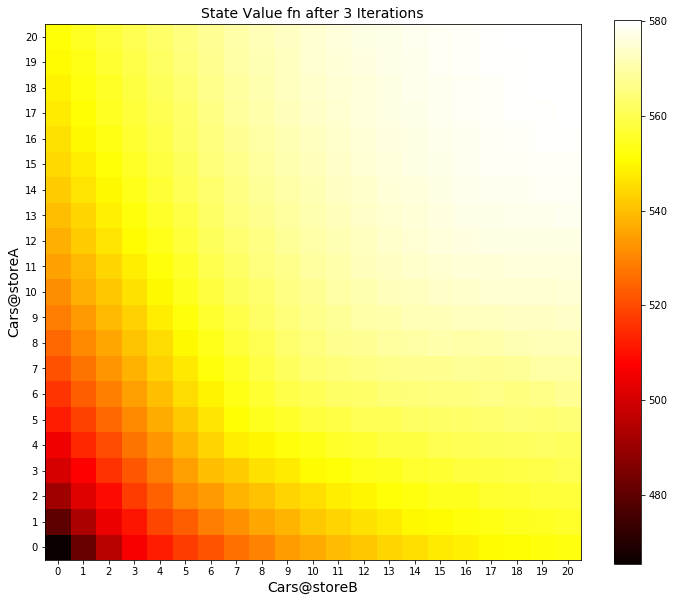

In [211]:
fig, ax = plt.subplots(figsize=(12,10))
heatmap = ax.imshow(stateval_2, cmap='hot') # this plots axis=0 as y axis, axis=1 as x-axis
ax.invert_yaxis() # invert y axis labels
plt.colorbar(heatmap)
ax.set_xticks(np.arange(0,jp.max_cars+1))[0]
ax.set_yticks(np.arange(0,jp.max_cars+1))[0]
ax.set_ylabel("Cars@storeA", fontsize=14)
ax.set_xlabel("Cars@storeB", fontsize=14)
ax.set_title('State Value fn after 3 Iterations', fontsize=14)

Text(0.5, 1.0, 'State Value fn after 2 Iterations')

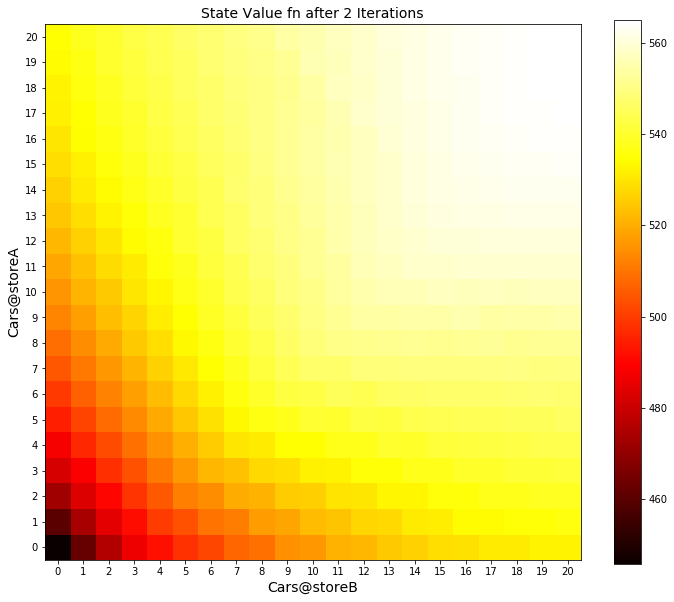

In [212]:
fig, ax = plt.subplots(figsize=(12,10))
heatmap = ax.imshow(stateval_1, cmap='hot') # this plots axis=0 as y axis, axis=1 as x-axis
ax.invert_yaxis() # invert y axis labels
plt.colorbar(heatmap)
ax.set_xticks(np.arange(0,jp.max_cars+1))[0]
ax.set_yticks(np.arange(0,jp.max_cars+1))[0]
ax.set_ylabel("Cars@storeA", fontsize=14)
ax.set_xlabel("Cars@storeB", fontsize=14)
ax.set_title('State Value fn after 2 Iterations', fontsize=14)

Text(0.5, 1.0, 'State Value fn after 1 Iterations')

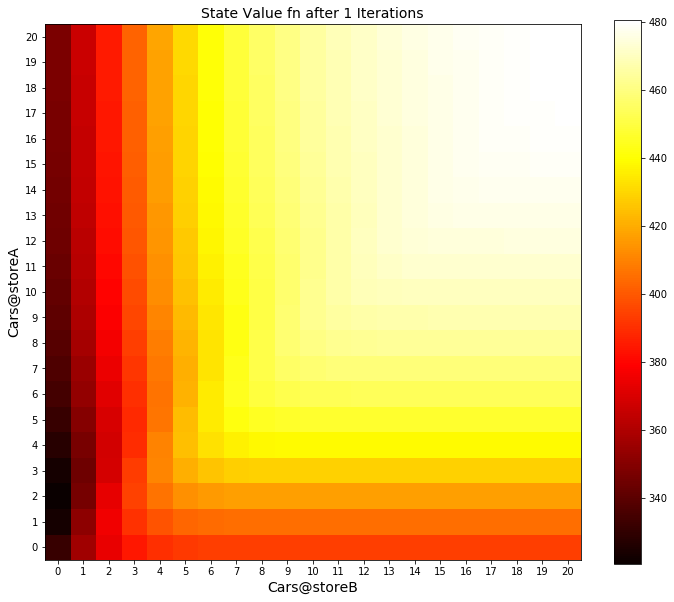

In [213]:
fig, ax = plt.subplots(figsize=(12,10))
heatmap = ax.imshow(stateval_0, cmap='hot') # this plots axis=0 as y axis, axis=1 as x-axis
ax.invert_yaxis() # invert y axis labels
plt.colorbar(heatmap)
ax.set_xticks(np.arange(0,jp.max_cars+1))[0]
ax.set_yticks(np.arange(0,jp.max_cars+1))[0]
ax.set_ylabel("Cars@storeA", fontsize=14)
ax.set_xlabel("Cars@storeB", fontsize=14)
ax.set_title('State Value fn after 1 Iterations', fontsize=14)

# ReSolve Jack Car rental problem with following changes
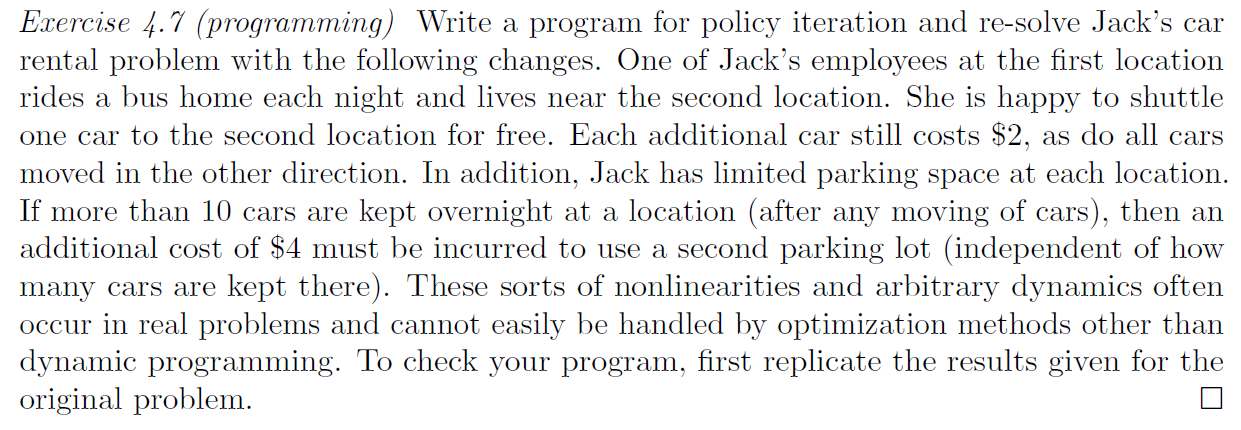

`Following changes are observed:`
- If car has to moved from storeA->storeB, one car can be moved for free, w/o any negative reward for that particular car movement
- If # of cars at any parking lot are more than 10 (after cars movement is completed), then additional negative reward of $4 is charged for using an additional parking lot

`NOTE`: Beacuse of this additonal non-linearities in the problem, expected_return function will change

In [214]:
class Jack():
    neg_reward = -2
    pos_reward = 10
    discount_fac = 0.9
    max_cars = 20
    max_cars_transfer = 5 
    neg_reward_excess_perking = -4
    excess_parking_threshold = 10
    
    def __init__(self, ret_rate, rent_rate, eps_prob): # these are the lambdas for the corresponding poisson distbns
        self.ret_rate  = ret_rate
        self.rent_rate = rent_rate
        self.eps_prob  = eps_prob
        self.ret_sample, self.ret_prob = self.gen_samples(self.ret_rate, self.eps_prob)
        self.rent_sample, self.rent_prob = self.gen_samples(self.rent_rate, self.eps_prob)
        
    
    def gen_samples(self, rate, eps_prob): # modelled as poisson distribn
        '''
        We will generate samples from this distiribution as long as the pmf is above some epsilon_prob
        There is no point in generating samples from distribution which has very low prob
        
        '''
        samples = []
        samples_prob = []
        sample = 0 # NOTE: init sample will always start from 0 since cars to be rented or returned are >=0
        while(1):
            prob = poisson.pmf(sample, rate)
            if prob > eps_prob:
                samples.append(sample)
                samples_prob.append(prob)
            else:
                if sample > rate: # crossed the mean point
                    break
            sample +=1
        
        return samples, samples_prob/np.sum(samples_prob)   
       

In [221]:
class JackPolicy():
    def __init__(self, storeA, storeB, max_steps_eval=10, eps_eval=0.1, max_steps_iter=4):
        self.storeA = storeA
        self.storeB = storeB
        self.states = [(x,y) for x in range(self.max_cars+1) for y in range(self.max_cars+1)] # list of tuples
        self.stateval = np.zeros((self.max_cars+1,self.max_cars+1)) # initial value of state value function
        # Note: as initiallized below, starting policy is for action = 0 for all states: Do Nothing!
        self.policy   = np.zeros((self.max_cars+1,self.max_cars+1)) # there is only 1 action possible per state in this problem
        self.max_steps_eval = max_steps_eval # maximum number of steps for policy evaluation
        self.eps_eval = eps_eval # for breaking out of policy evaluation
        self.max_steps_iter = max_steps_iter # maximum num of steps for policy iteration
        
        
    def __getattr__(self, key):
        return getattr(self.__dict__['storeA'], key)
        
    
    def policy_eval(self): 
        print("--- starting New policy eval iteration -----")
        counter = 0
        while(counter < self.max_steps_eval):
            print("--- policy eval iteration -----")
            counter += 1
            delta = 0
            # loop over every state
            for i in range(self.stateval.shape[0]):
                for j in range(self.stateval.shape[1]):
                    old_stateval = self.stateval[i][j]
                    self.stateval[i][j]  = self.expected_return([i,j], self.policy[i][j])
                    delta = np.maximum(delta,np.abs(old_stateval - self.stateval[i][j]))
            print(delta)
            if delta < self.eps_eval:
                break
        
        
    def expected_return(self, state, action):
        '''
        state: list of integer corresponding to state (i.e cars@storeA and cars@storeB)
        action: integer corresponding to the policy under evaluation for the given state (number b/w -5 and 5)
        '''
       
        # because of the action of moving cars, the state will change so update the state value
        state = [min(max(state[0]-action,0), self.max_cars), min(max(state[1]+action,0), self.max_cars)] # make sure that number of 0<= #cars <= 20
        
        # give the negative reward due to movement of cars
        if action > 0: #car moved from storeA->storeB, then one car can be moved for free
            reward = self.neg_reward * (action-1)    # this reward is given with prob 1
        else:
            reward = self.neg_reward * abs(action)   # this reward is given with prob 1
            
        # additonal negative reward is given if # of cars at any parking lot exceed a threshold after car movement is completed
        if state[0] > self.excess_parking_threshold:
            reward += self.neg_reward_excess_perking
            
        if state[1] > self.excess_parking_threshold:
            reward += self.neg_reward_excess_perking
        
        # after the above update of the state, the environment starts acting leading to all possible state outcomes as a 
        # consequence of returns and rental at both stores
        
        for rent_storeA in self.storeA.rent_sample: # this is list, hence iterable
            for rent_storeB in self.storeA.rent_sample: # this is list, hence iterable
                for ret_storeA in self.storeA.ret_sample: # this is list, hence iterable
                    for ret_storeB in self.storeB.ret_sample: # this is list, hence iterable
                        
                        # probability of this event is multplication of indiv. (since indep. RVs)
                        prob = self.storeA.rent_prob[rent_storeA] * self.storeA.ret_prob[rent_storeB] \
                               * self.storeA.ret_prob[ret_storeA] * self.storeB.ret_prob[ret_storeB]
                            
                        # compute the postive reward, before that we have to find number of cars that can be rented out
                        cars_rent_A = min(state[0],rent_storeA)
                        cars_rent_B = min(state[1],rent_storeB)
                        pos_reward = (cars_rent_A + cars_rent_B)*self.pos_reward
                        
                        # as a consequence of car rentals and returns of this event, the state will change, compute the new state
                        tmp_state = [0,0]
                        tmp_state[0] = int(min(max(state[0] - cars_rent_A + ret_storeA, 0), self.max_cars))
                        tmp_state[1] = int(min(max(state[1] - cars_rent_A + ret_storeA, 0), self.max_cars))
                                                
                        # compute the discounted reward for the event (or state) and keep accumulating
                        reward += prob*(pos_reward + self.discount_fac * self.stateval[tmp_state[0], tmp_state[1]])
        
        
        return reward
        
    
    def policy_improvement(self):
        policy_stable = 0
        
        # loop over every state
        for i in range(self.stateval.shape[0]):
            for j in range(self.stateval.shape[1]):
                old_action = self.policy[i][j]
                # Now try every possible action and compute the expected reward and choose greedy action
                # first find the possible actions given the state
                act_12 = min(i,self.max_cars_transfer) # you can transfer this from storeA->storeB
                act_21 = -1*min(j,self.max_cars_transfer) # you can transfer this from storeB->storeA
                
                max_reward = -1e9
                for action in range(act_21, act_12+1): # go through every possible action given the state
                    reward = self.expected_return([i,j], action)
                    if reward > max_reward:
                        max_reward = reward
                        self.policy[i][j] = action #update policy to greedy policy
                
                if old_action!=self.policy[i][j]:
                    policy_stable += 1 # if any of the state policy is changed, it will increment the counter
                    
        # check if policy is stable
        if np.sum(policy_stable) > 0:
            return False
        else: return True
    
    def policy_iteration(self, save_intermediate=False):
        counter = 0
        while(counter < self.max_steps_iter):            
            self.policy_eval()
            flag = self.policy_improvement()
            if save_intermediate:
                outFile = 'Policy_' + str(counter)
                np.save(outFile, self.policy)
                outFile = 'StateVal_' + str(counter)
                np.save(outFile, self.stateval)
                
            if flag==True:
                print("Policy improvement converged..., exiting early!")
                break
                
            counter += 1
        
        
        return self.stateval, self.policy
    
    def show(self):
        pass

In [222]:
eps_prob = 0.01
storeA = Jack(3,3,eps_prob)
storeB = Jack(4,2,eps_prob)

In [223]:
jp = JackPolicy(storeA, storeB)
stateval, policy = jp.policy_iteration(save_intermediate=True)

--- starting New policy eval iteration -----
--- policy eval iteration -----
91.01664109754412
--- policy eval iteration -----
71.59936636413153
--- policy eval iteration -----
58.93613470405586
--- policy eval iteration -----
51.259894043124234
--- policy eval iteration -----
45.21011183035469
--- policy eval iteration -----
39.19567596658669
--- policy eval iteration -----
33.69482329410755
--- policy eval iteration -----
28.829948646838886
--- policy eval iteration -----
24.596111407656622
--- policy eval iteration -----
20.943387433109876
--- starting New policy eval iteration -----
--- policy eval iteration -----
137.37518053815626
--- policy eval iteration -----
28.505512274355567
--- policy eval iteration -----
13.522547799504878
--- policy eval iteration -----
11.391410525324886
--- policy eval iteration -----
9.604949832678244
--- policy eval iteration -----
8.225002346012161
--- policy eval iteration -----
7.036933019149501
--- policy eval iteration -----
5.998424425086398
--

In [225]:
#after 4th pass
stateval_3 = np.load('StateVal_3.npy')
policy_3   = np.load('Policy_3.npy')
#after 3rd pass
stateval_2 = np.load('StateVal_2.npy')
policy_2   = np.load('Policy_2.npy')
#after 2nd pass
stateval_1 = np.load('StateVal_1.npy')
policy_1   = np.load('Policy_1.npy')
#after 1st pass
stateval_0 = np.load('StateVal_0.npy')
policy_0   = np.load('Policy_0.npy')

Text(0.5, 1.0, 'Policy after 4 Iterations')

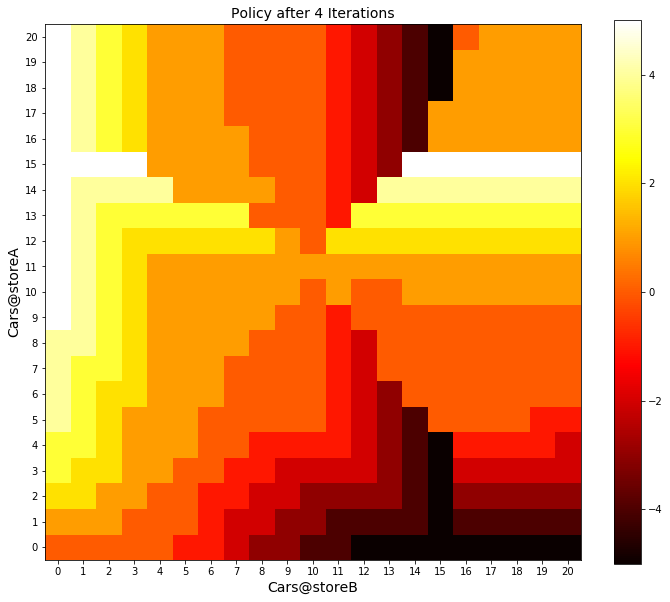

In [226]:
fig, ax = plt.subplots(figsize=(12,10))
heatmap = ax.imshow(policy_3, cmap='hot') # this plots axis=0 as y axis, axis=1 as x-axis
ax.invert_yaxis() # invert y axis labels
plt.colorbar(heatmap)
ax.set_xticks(np.arange(0,jp.max_cars+1))[0]
ax.set_yticks(np.arange(0,jp.max_cars+1))[0]
ax.set_ylabel("Cars@storeA", fontsize=14)
ax.set_xlabel("Cars@storeB", fontsize=14)
ax.set_title('Policy after 4 Iterations', fontsize=14)

Text(0.5, 1.0, 'State Value fn after 4 Iterations')

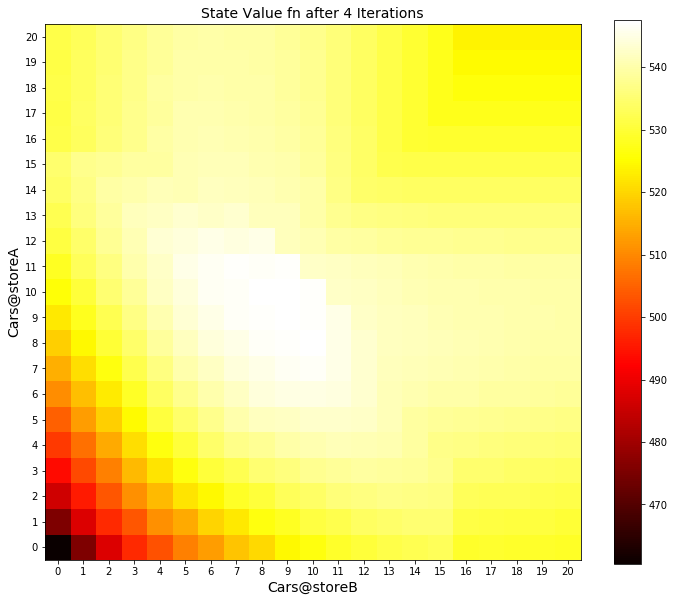

In [227]:
fig, ax = plt.subplots(figsize=(12,10))
heatmap = ax.imshow(stateval_3, cmap='hot') # this plots axis=0 as y axis, axis=1 as x-axis
ax.invert_yaxis() # invert y axis labels
plt.colorbar(heatmap)
ax.set_xticks(np.arange(0,jp.max_cars+1))[0]
ax.set_yticks(np.arange(0,jp.max_cars+1))[0]
ax.set_ylabel("Cars@storeA", fontsize=14)
ax.set_xlabel("Cars@storeB", fontsize=14)
ax.set_title('State Value fn after 4 Iterations', fontsize=14)